In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
game = pd.read_csv('games.csv')
#prefer price in USD, add describer
game = game.rename(columns = {'Price' : 'Price in USD'})
#drop some NA values + Playtests
#dropna isn't working for some reason, so I have to do drops like this
nannameindex = game.loc[game.Name.isna()].index
game.drop(nannameindex, inplace = True)
nangenindex = game.loc[game.Genres.isna()].index
game.drop(nangenindex, inplace = True)
game.drop(game.loc[game.Name.str.contains('Playtest')].index, inplace = True)
#drop unneeded tags
game.drop(columns = ['DLC count', 'About the game','Supported languages', 'Full audio languages','Score rank','Reviews', 'Header image', 'Website', 'Support url', 'Support email', 'Metacritic url', 'Achievements', 'Recommendations','Notes','Screenshots', 'Movies', 'Developers', 'Publishers', 'Categories', 'Metacritic score', 'Peak CCU'], inplace = True)
#drop software with the Utilities tag
game.drop(game.loc[game['Genres'].str.contains('Utilities', na = False)].index, inplace = True)

In [3]:
#Make large numbers readable
replace_values = {'0 - 0' : '0','0 - 20000' : '20,000 and less', '20000 - 50000' : '20,000 to 50,000', '50000 - 100000' : '50,000 to 100,000','100000 - 200000' : '100,000 to 200,000', '200000 - 500000' : '200,000 to 500,000', '500000 - 1000000' : '500,000 to 1 million','1000000 - 2000000' : '1 million to 2 million','2000000 - 5000000' : '2 million to 5 million', '5000000 - 10000000' : '5 million to 10 million', '10000000 - 20000000' : '10 million to 20 million', '20000000 - 50000000': '20 million to 50 million', '50000000 - 100000000' : '50 million to 100 million', '100000000 - 200000000' : '100 million to 200 million' }
game.replace({'Estimated owners' : replace_values}, inplace = True)
#Change Release date to datetime format
game['Release date'].replace(',', '', regex = True, inplace = True)
game['Release date'] = pd.to_datetime(game['Release date'])

In [4]:
#identify how many games qualify for each genre
genre_list = game.Genres
genre_list = genre_list.str.split(',', expand = True)
glist = []
for cols in genre_list.columns:
    tlist = genre_list[cols].value_counts().to_frame(cols).sort_index().reset_index()
    if cols == 0:
        glist = tlist
    else:
        glist = glist.merge(tlist, on = 'index', how = 'left')
glist['Sum'] = glist.sum(axis = 1, numeric_only = True)
glist.sort_values(by = 'Sum', ascending = False)
glist.rename(columns = {'index' : 'genres'}, inplace = True)

In [5]:
#drop non-game software
gcols = glist[glist['Sum']< 1000]
drop_check = game[['AppID', 'Genres']]

In [6]:
#save game releated genre tags
savelist = ("Nudity", "Sexual Content", "Violent", "Education", "Gore")
for item in savelist:
    temp = gcols.loc[gcols['genres'].str.contains(str(item))].index
    gcols.drop(temp, inplace = True)

C:\Users\John\AppData\Local\Temp\ipykernel_17588\2460550307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcols.drop(temp, inplace = True)


In [7]:
drop_list = pd.DataFrame()
for genre in gcols.genres:
    temp = drop_check.loc[drop_check.Genres.str.strip().str.contains(genre, case = False)]
    drop_list = pd.concat([drop_list, temp], ignore_index = True)

In [8]:
#use boolean indexing and invert to remove undesired genres
game = game[~game.AppID.isin(drop_list.AppID)]

In [9]:
#final null checking
for col in game.columns:
    if game[col].isnull().any() == True:
        print(col)

Tags


In [10]:
game

,AppID,Name,Release date,Estimated owners,Required age,Price in USD,Windows,Mac,Linux,User score,Positive,Negative,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Genres,Tags
0,20200,Galactic Bowling,2008-10-21,"20,000 and less",0,19.99,True,False,False,0,6,11,0,0,0,0,"Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,2017-10-12,"20,000 and less",0,0.99,True,True,False,0,53,5,0,0,0,0,"Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,2021-11-17,"20,000 and less",0,4.99,True,False,False,0,0,0,0,0,0,0,"Action,Adventure,Indie,Strategy",NaN
3,1355720,Henosis™,2020-07-23,"20,000 and less",0,5.99,True,True,True,0,3,0,0,0,0,0,"Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,2020-02-03,"20,000 and less",0,0.00,True,True,False,0,50,8,0,0,0,0,"Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,2669080,Mannerheim's Saloon Car,2024-01-02,0,0,0.00,True,False,False,0,0,0,0,0,0,0,"Adventure,Simulation",NaN
85099,2736910,Beer Run,2024-01-03,0,0,0.00,True,False,False,0,0,0,0,0,0,0,"Casual,Indie",NaN
85100,2743220,My Friend The Spider,2024-01-04,0,0,0.00,True,False,False,0,0,0,0,0,0,0,"Adventure,Simulation",NaN
85101,2293130,Path of Survivors,2024-01-08,0,0,3.99,True,False,False,0,0,0,0,0,0,0,"Action,Casual,Indie,RPG,Simulation",NaN


In [11]:
review_score = pd.DataFrame(game[["AppID","Positive", "Negative" ]])
review_score['Total Reviews'] = review_score['Positive'] + review_score['Negative']
review_score['Pos_Percent'] = review_score['Positive'] / (review_score['Total Reviews'])

In [12]:
review_score['Pos_Percent'] = review_score['Pos_Percent'].fillna(0)

In [13]:
review_score['Pos_Percent'].describe()

count    80133.000000
mean         0.587688
std          0.379027
min          0.000000
25%          0.200000
50%          0.724005
75%          0.912313
max          1.000000
Name: Pos_Percent, dtype: float64

In [14]:
#remove games with less than 10 reviews
game = game[~game.AppID.isin(review_score.loc[review_score['Total Reviews'] < 10].AppID)]

In [15]:
game.reset_index(drop=True, inplace = True)

In [16]:
game

,AppID,Name,Release date,Estimated owners,Required age,Price in USD,Windows,Mac,Linux,User score,Positive,Negative,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Genres,Tags
0,20200,Galactic Bowling,2008-10-21,"20,000 and less",0,19.99,True,False,False,0,6,11,0,0,0,0,"Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,2017-10-12,"20,000 and less",0,0.99,True,True,False,0,53,5,0,0,0,0,"Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1139950,Two Weeks in Painland,2020-02-03,"20,000 and less",0,0.00,True,True,False,0,50,8,0,0,0,0,"Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
3,1469160,Wartune Reborn,2021-02-26,"50,000 to 100,000",0,0.00,True,False,False,0,87,49,0,0,0,0,"Adventure,Casual,Free to Play,Massively Multip...","Turn-Based Combat,Massively Multiplayer,Multip..."
4,1659180,TD Worlds,2022-01-09,"20,000 and less",0,10.99,True,False,False,0,21,7,0,0,0,0,"Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41784,1281490,The Night is Grey,2024-01-05,"20,000 and less",0,14.39,True,True,False,0,14,3,0,0,0,0,"Adventure,Casual,Indie","Point & Click,Adventure,Indie,Psychological Ho..."
41785,2234690,The Day Before You Gone,2024-01-05,"20,000 to 50,000",0,7.64,True,False,False,0,11,0,0,0,0,0,"Adventure,Indie","Adventure,Visual Novel,Fantasy,Medieval,Psycho..."
41786,2674190,Akai Onna,2024-01-04,"20,000 and less",0,2.54,True,False,False,0,19,2,0,0,0,0,"Casual,Indie","Walking Simulator,Casual,First-Person,3D,Horro..."
41787,2459870,Drop Doll,2024-01-05,"20,000 and less",0,1.79,True,False,False,0,24,4,0,0,0,0,"Casual,Early Access","Mature,Sexual Content,Casual,Relaxing,NSFW,2D,..."


In [17]:
review_score = pd.DataFrame(game[["AppID","Positive", "Negative" ]])
review_score['Total Reviews'] = review_score['Positive'] + review_score['Negative']
review_score['Pos_Percent'] = review_score['Positive'] / (review_score['Total Reviews'])

In [18]:
review_score.Pos_Percent.describe(percentiles = [.2,.4,.6,.8])

count    41789.000000
mean         0.761503
std          0.188667
min          0.000000
20%          0.611111
40%          0.751985
50%          0.804301
60%          0.849044
80%          0.926511
max          1.000000
Name: Pos_Percent, dtype: float64

todo: use pos_percent to separate games into 5 groups, 1-5, where 5 = 1 and 1 = 0
score out of 10 for final?
fix multiilabel binarizer so each genre is its own column

In [19]:
genre_sep = pd.DataFrame(game[['AppID', 'Genres']])

In [20]:
genre_sep.Genres = genre_sep.Genres.str.split(",")

In [21]:
MLB = MultiLabelBinarizer(sparse_output = True)

In [22]:
#pull genre column, fit and transform, with the order important -  fit and transform in one step doesn't work
f1 = genre_sep.Genres
MLB.fit(f1)
MLB.transform(f1)
cats = pd.DataFrame.sparse.from_spmatrix(MLB.transform(f1), index = genre_sep.index, columns = MLB.classes_)

In [23]:
cats

,Action,Adventure,Casual,Early Access,Education,Free to Play,Gore,Indie,Massively Multiplayer,Movie,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41784,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41785,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41786,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41787,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
genre_sep.drop("Genres", axis = 1, inplace = True)

In [25]:
genre_sep

,AppID
0,20200
1,655370
2,1139950
3,1469160
4,1659180
...,...
41784,1281490
41785,2234690
41786,2674190
41787,2459870


In [26]:
genre_sep = pd.concat([genre_sep, cats], axis = 1)

In [27]:
genre_sep

,AppID,Action,Adventure,Casual,Early Access,Education,Free to Play,Gore,Indie,Massively Multiplayer,Movie,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent
0,20200,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,655370,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1139950,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1469160,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
4,1659180,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41784,1281490,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41785,2234690,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41786,2674190,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41787,2459870,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
genre_sep.loc[genre_sep.Movie == 1]

,AppID,Action,Adventure,Casual,Early Access,Education,Free to Play,Gore,Indie,Massively Multiplayer,Movie,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent
29795,436180,1,1,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0


In [29]:
T0 = pd.DataFrame(game.loc[game["AppID"].isin( review_score.loc[review_score.Pos_Percent < .62].AppID)].AppID)

In [30]:
T1 = pd.DataFrame(game.loc[game["AppID"].isin( review_score.loc[(review_score.Pos_Percent >= .62) & (review_score.Pos_Percent < .76)].AppID)].AppID)

In [31]:
T2 = pd.DataFrame(game.loc[game["AppID"].isin( review_score.loc[(review_score.Pos_Percent >= .76) & (review_score.Pos_Percent < .84)].AppID)].AppID)

In [32]:
T3 = pd.DataFrame(game.loc[game["AppID"].isin( review_score.loc[(review_score.Pos_Percent >= .84) & (review_score.Pos_Percent < .92)].AppID)].AppID)

In [33]:
T4 = pd.DataFrame(game.loc[game["AppID"].isin( review_score.loc[(review_score.Pos_Percent >= .92)].AppID)].AppID)

In [34]:
T4

,AppID
5,1178150
10,1454010
12,1330820
13,346560
41,1944730
...,...
41778,2487350
41779,2715280
41780,2287140
41783,2315020


In [35]:
#create Tier list based on positive review percentage and ownerbase
Tier = pd.DataFrame(game[["AppID", "Name"]])

In [36]:
Tier[[('R_Score'), ('Owner_Score')]] = np.NaN

In [37]:
Tier

,AppID,Name,R_Score,Owner_Score
0,20200,Galactic Bowling,NaN,NaN
1,655370,Train Bandit,NaN,NaN
2,1139950,Two Weeks in Painland,NaN,NaN
3,1469160,Wartune Reborn,NaN,NaN
4,1659180,TD Worlds,NaN,NaN
...,...,...,...,...
41784,1281490,The Night is Grey,NaN,NaN
41785,2234690,The Day Before You Gone,NaN,NaN
41786,2674190,Akai Onna,NaN,NaN
41787,2459870,Drop Doll,NaN,NaN


In [38]:
Tier.loc[Tier['AppID'].isin(T0.AppID), 'R_Score'] = 1

In [39]:
Tier.loc[Tier['AppID'].isin(T1.AppID), 'R_Score'] = 2

In [40]:
Tier.loc[Tier['AppID'].isin(T2.AppID), 'R_Score'] = 3

In [41]:
Tier.loc[Tier['AppID'].isin(T3.AppID), 'R_Score'] = 4

In [42]:
Tier.loc[Tier['AppID'].isin(T4.AppID), 'R_Score'] = 5

In [43]:
Tier

,AppID,Name,R_Score,Owner_Score
0,20200,Galactic Bowling,1.0,NaN
1,655370,Train Bandit,4.0,NaN
2,1139950,Two Weeks in Painland,4.0,NaN
3,1469160,Wartune Reborn,2.0,NaN
4,1659180,TD Worlds,2.0,NaN
...,...,...,...,...
41784,1281490,The Night is Grey,3.0,NaN
41785,2234690,The Day Before You Gone,5.0,NaN
41786,2674190,Akai Onna,4.0,NaN
41787,2459870,Drop Doll,4.0,NaN


In [44]:
game["Estimated owners"].value_counts()

20,000 and less               25404
20,000 to 50,000               6538
50,000 to 100,000              3494
100,000 to 200,000             2400
200,000 to 500,000             2068
500,000 to 1 million            890
1 million to 2 million          513
2 million to 5 million          328
5 million to 10 million          91
10 million to 20 million         38
20 million to 50 million         20
50 million to 100 million         4
100 million to 200 million        1
Name: Estimated owners, dtype: int64

In [45]:
Tier.loc[Tier.AppID.isin(game.loc[(game["Estimated owners"] == "20,000 and less") | (game["Estimated owners"] == "20,000 to 50,000") | (game["Estimated owners"] == "50,000 to 100,000") ].AppID), "Owner_Score"] = 1

In [46]:
Tier.loc[Tier.AppID.isin(game.loc[(game["Estimated owners"] == "100,000 to 200,000") | (game["Estimated owners"] == "200,000 to 500,000") | (game["Estimated owners"] == "500,000 to 1 million") ].AppID), "Owner_Score"] = 2

In [47]:
Tier.loc[Tier.AppID.isin(game.loc[(game["Estimated owners"] == "1 million to 2 million") | (game["Estimated owners"] == "2 million to 5 million") | (game['Estimated owners'] == "5 million to 10 million")].AppID), "Owner_Score"] = 3

In [48]:
Tier.loc[Tier.AppID.isin(game.loc[(game["Estimated owners"] == "10 million to 20 million") | (game["Estimated owners"] == "20 million to 50 million") | (game['Estimated owners'] == "50 million to 100 million") | (game['Estimated owners'] == '100 million to 200 million')].AppID), "Owner_Score"] = 3

In [49]:
Tier["Success_Score"] = Tier.R_Score + Tier.Owner_Score

In [50]:
Tier.Success_Score.value_counts()

6.0    9518
3.0    7989
5.0    7905
2.0    7890
4.0    6905
7.0    1283
8.0     299
Name: Success_Score, dtype: int64

In [51]:
Tier

,AppID,Name,R_Score,Owner_Score,Success_Score
0,20200,Galactic Bowling,1.0,1.0,2.0
1,655370,Train Bandit,4.0,1.0,5.0
2,1139950,Two Weeks in Painland,4.0,1.0,5.0
3,1469160,Wartune Reborn,2.0,1.0,3.0
4,1659180,TD Worlds,2.0,1.0,3.0
...,...,...,...,...,...
41784,1281490,The Night is Grey,3.0,1.0,4.0
41785,2234690,The Day Before You Gone,5.0,1.0,6.0
41786,2674190,Akai Onna,4.0,1.0,5.0
41787,2459870,Drop Doll,4.0,1.0,5.0


In [92]:
gcol = genre_sep.columns.tolist()
removal = ['AppID', 'Movie']
gcol = [g for g in gcol if g not in removal]

In [54]:
gdata = pd.DataFrame(columns = ('genre', 'g_mean', 'g_min', 'g_max', '.25', '.75'))
def genre_data(genre):
    global gdata
    #get success score by genre matching + AppID
    g_mean = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[genre] == 1].AppID)].Success_Score.mean()
    g_min = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[genre] == 1].AppID)].Success_Score.min()
    g_max = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[genre] == 1].AppID)].Success_Score.max()
    IQ25 = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[genre] == 1].AppID)].Success_Score.quantile(.25)
    IQ75 = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[genre] == 1].AppID)].Success_Score.quantile(.75)
    gdata.loc[-1] = [genre, g_mean,g_min,g_max,IQ25,IQ75]  #append found results to end of gdata
    gdata.index = gdata.index + 1 #increment index
    gdata = gdata.sort_index()

In [55]:
for genre in gcol:
    genre_data(genre)
    


todo: list of genres and get max, min, mean, .25, .75 and make box and whisker comparison


In [68]:
gdata.sort_values(by = 'g_mean')

,genre,g_mean,g_min,g_max,.25,.75
0,Violent,2.957219,2.0,7.0,2.0,4.0
10,Gore,2.995595,2.0,7.0,2.0,4.0
7,Nudity,3.161616,2.0,6.0,2.0,4.0
8,Massively Multiplayer,3.450758,2.0,8.0,2.0,4.0
4,Sexual Content,3.544304,2.0,7.0,2.0,4.5
3,Simulation,3.912290,2.0,8.0,3.0,5.0
2,Sports,3.922354,2.0,8.0,3.0,5.0
5,Racing,3.933250,2.0,8.0,3.0,5.0
13,Early Access,4.019912,2.0,8.0,3.0,5.0
11,Free to Play,4.024649,2.0,8.0,3.0,5.0


In [86]:
gcol

['Action',
 'Adventure',
 'Casual',
 'Early Access',
 'Education',
 'Free to Play',
 'Gore',
 'Indie',
 'Massively Multiplayer',
 'Nudity',
 'RPG',
 'Racing',
 'Sexual Content',
 'Simulation',
 'Sports',
 'Strategy',
 'Violent']

plotting

In [93]:
for i in range(0, len(gcol)):
    
    rem = gcol.pop()
    print(rem)
    i = i +1
    

Violent
Strategy
Sports
Simulation
Sexual Content
Racing
RPG
Nudity
Massively Multiplayer
Indie
Gore
Free to Play
Education
Early Access
Casual
Adventure
Action


IndexError: pop from empty list

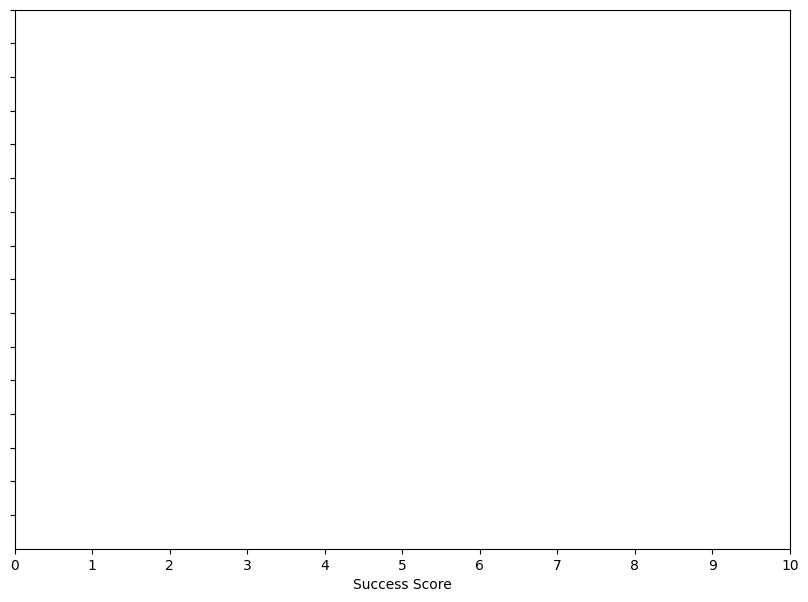

In [97]:
#testplot
#need to create plot outside of loop
#make horizontal boxplots in one graph
#make labels relative to plot

#how to plot multiple graphs on same plot?

fig  = plt.figure(figsize = (10,7))
yti = []
for i in range(0, len(gcol)):
    
    rem = gcol.pop()
    yti = yti.append[rem]
    data = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep[rem] == 1].AppID)].Success_Score
    bp = plt.boxplot(data, showmeans = True, vert = False )
    for line in bp['means']:
        x,y = line.get_xydata()[0]
        m_text = round(data.mean(),3)
        text = "mean : %f" %m_text
        plt.text(x -.1 , y + .11 , s =  text, va = 'top')
    i = i +1
#data = Tier.loc[Tier.AppID.isin(genre_sep.loc[genre_sep["Action"] == 1].AppID)].Success_Score



plt.xticks(range(0,11))
plt.xlabel("Success Score")
plt.yticks(range(1,17),)
#plt.yticks(range(1, len(gcol)),???)
plt.show()

In [ ]:
bp